This notebook will test the Super GAN framework's effectiveness at generating synthetic EEG data. Specifically, we will generate data for each class in the EEG Seizure Dectection Dataset, and then we will train a classifier on the synthetic data and test it on the real data (TSTR) to evaluate the realism of the synthetic dataset. To simplify the problem, we will consolidate the data into two classes: the subject did not have a seizure (class 0), and the subject did have a seizure (class 1). 

More information on the dataset is available at the following links:
    - https://www.kaggle.com/harunshimanto/epileptic-seizure-recognition/version/2
    - https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

For more information regarding this GAN framework, please see the following works:

    R. Saeedi, S. Norgaard and A.H. Gebremedhin, A Closed-loop Deep Learning Architecture for Robust Activity Recognition using Wearable Sensors, 2017 IEEE International Conference on Big Data (BigData 2017).
    S. Norgaard, R. Saeedi, K. Sasani, and A.H. Gebremedhin, Synthetic Sensor Data Generation for Health Applications: A Supervised Deep Learning Approach, IEEE Engineering in Medicine and Biology Society Conference (EMBC 2018).


In [22]:
# Imports 
import numpy as np
import pandas as pd
import tensorflow as tf
import training_module as train
import input_module as input_mod
import saving_module as save
from keras.models import Model, load_model, Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Lambda, Conv1D, MaxPooling1D
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from random import shuffle
import models, sys, h5py, keras
import matplotlib.pyplot as plt

# Global variables/constants defined
DATAFILE = "/Users/nmb1331/Downloads/Epileptic_Seizure_Recognition.csv"
NUM_OG_CLASSES = 5

# Global variables for training
NUM_CLASSES = 2
NUM_CLASSIFIER_EPOCHS = 12
NUM_TSTR_CLASSIFIER_EPOCHS = 20
NUM_GAN_EPOCHS = 40 # Formerly 25. Curious if RTS or SFD is more important
CLASSIFIER_TRAIN_RATIO = 0.8
NUM_SYNTHETIC_SAMPLES = 2000 # Per class
NUM_STATS = 9 # Number of statistics computed for loss function. Do NOT change

# PARAMETERS RELATED TO TRAINING
latent_dim = 70 #length of random input fed to generator (should it be num_classes + 1?)
epochs = 100 #num training epochs
batch_size = 30 #num instances generated for G/D training
test_size = 100 #num instances generated for validating data
real_synthetic_ratio = 5 #num synthetic instances per real instance for computing RTS metric
synthetic_synthetic_ratio = 10 #num synthetic instances to compare for computing STS metric
disc_lr = .08 #learning rate of discriminator
accuracy_threshold = 0.95 #threshold to stop generator training

# WEIGHTS FOR DIFFERENT TERMS IN THE LOSS FUNCTION
D_loss_weight = 1.25
C_loss_weight = 0.75
SFD_loss_weight = 1

First, we'll read in the data, and make some preliminary plots:

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


         1      2      3      4      5      6      7      8      9      10   \
11201 -0.085 -0.141 -0.181 -0.163 -0.113 -0.072 -0.060 -0.073 -0.079 -0.066   
1080  -0.083 -0.096 -0.109 -0.116 -0.123 -0.126 -0.134 -0.143 -0.152 -0.162   
10036 -0.002 -0.007 -0.003  0.009  0.016  0.019  0.030  0.036  0.045  0.049   
3364  -0.035 -0.039 -0.041 -0.044 -0.041 -0.042 -0.040 -0.043 -0.049 -0.054   
4429   0.008 -0.003 -0.016 -0.030 -0.036 -0.039 -0.034 -0.027 -0.026 -0.016   

       ...    169    170    171    172    173    174    175    176    177  \
11201  ... -0.095 -0.089 -0.085 -0.071 -0.055 -0.039 -0.026 -0.016 -0.017   
1080   ...  0.031  0.036  0.039  0.042  0.044  0.047  0.046  0.046  0.042   
10036  ...  0.002 -0.004 -0.011 -0.017 -0.021 -0.020 -0.021 -0.019 -0.011   
3364   ... -0.178 -0.180 -0.181 -0.189 -0.185 -0.178 -0.172 -0.157 -0.141   
4429   ... -0.017 -0.019 -0.011 -0.009 -0.013 -0.011 -0.007  0.000  0.015   

         178  
11201 -0.029  
1080   0.031  
10036 -0.005  
33

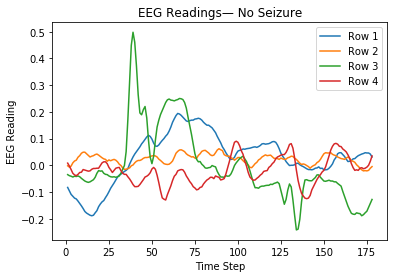

      1      2      3      4      5      6      7      8      9      10   ...  \
1   0.386  0.382  0.356  0.331  0.320  0.315  0.307  0.272  0.244  0.232  ...   
8  -0.278 -0.246 -0.215 -0.191 -0.177 -0.167 -0.157 -0.139 -0.118 -0.092  ...   
11 -0.167 -0.230 -0.280 -0.315 -0.338 -0.369 -0.405 -0.392 -0.298 -0.140  ...   
20  0.410  0.451  0.491  0.541  0.581  0.641  0.736  0.757  0.692  0.435  ...   
22 -0.264 -0.189 -0.117 -0.045  0.020  0.070  0.111  0.143  0.161  0.179  ...   

      169    170    171    172    173    174    175    176    177    178  
1   0.168  0.164  0.150  0.146  0.152  0.157  0.156  0.154  0.143  0.129  
8  -0.386 -0.400 -0.379 -0.336 -0.281 -0.226 -0.174 -0.125 -0.079 -0.040  
11  0.415  0.423  0.434  0.416  0.374  0.319  0.268  0.215  0.165  0.103  
20  0.409  0.415  0.428  0.463  0.510  0.562  0.607  0.667  0.748  0.763  
22 -0.227 -0.231 -0.221 -0.248 -0.321 -0.444 -0.530 -0.548 -0.536 -0.486  

[5 rows x 178 columns]


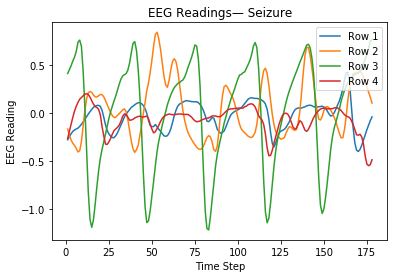

In [23]:
# Read in the data; seperate by class
eeg_raw = pd.read_csv(DATAFILE)
class_df_dict = {}
for y_val, eeg_df in eeg_raw.groupby('y'):
    eeg_df.columns = [int(i) for i in range(1, (len(eeg_df.columns)+1))]
    eeg_df.rename(columns={ eeg_df.columns[len(eeg_df.columns)-1]: "y" }, inplace=True)
    class_df_dict[y_val] = eeg_df

# Join non-seizure classes into one dataset
#X_0_df = pd.concat([class_df_dict[x] for x in range(2, NUM_OG_CLASSES+1)])
X_0_df = class_df_dict[2]
X_0_df.loc[:,'y'] = 0
Y_0_df = X_0_df['y']
del X_0_df['y']
X_0_df = X_0_df.apply(pd.to_numeric)
X_0_df = X_0_df.sample(frac=1) # Shuffle rows

# Normalize
X_0_df = X_0_df / 1000
print(X_0_df.head(5))

# Make plots of 4 rows, non-seizure
for i in range(1, 5):
    plt.plot(X_0_df.columns, X_0_df.iloc[i], label="Row {}".format(i))
plt.xlabel('Time Step')
plt.ylabel('EEG Reading')
plt.title('EEG Readings— No Seizure')
plt.gca().legend(loc="upper right")
plt.show()

# Build seizure dataset
X_1_df = class_df_dict[1]
X_1_df.loc[:,'y'] = 1
Y_1_df = X_1_df['y']
del X_1_df['y']
X_1_df = X_1_df.apply(pd.to_numeric)
X_0_df = X_0_df.sample(frac=1) # Shuffle rows

# Normalize
X_1_df = X_1_df / 1000
print(X_1_df.head(5))

# Make plots of 4 rows, with seizure
for i in range(1, 5):
    plt.plot(X_1_df.columns, X_1_df.iloc[i], label="Row {}".format(i))
plt.xlabel('Time Step')
plt.ylabel('EEG Reading')
plt.title('EEG Readings— Seizure')
plt.gca().legend(loc="upper right")
plt.show()

Now that we have the plots generated and the datasets created, lets convert them to numpy arrays:

In [24]:
# Join them together
Y_df = pd.concat((Y_0_df, Y_1_df))
X_df = pd.concat((X_0_df, X_1_df))

# Build X_0 and Y_0 datasets
Y_0 = Y_0_df.values.T
Y_0 = Y_0.reshape((Y_0.shape[0], 1))
X_0 = X_0_df.values
#X_0 = normalize(X_0)
X_0 = X_0.reshape((X_0.shape[0], X_0.shape[1], 1))

Y_1 = Y_1_df.values.T
Y_1 = Y_1.reshape((Y_1.shape[0], 1))
X_1 = X_1_df.values
#X_1 = normalize(X_1)
X_1 = X_1.reshape((X_1.shape[0], X_1.shape[1], 1))

# Convert to numpy arrays, reshape
Y = Y_df.values.T
Y = Y.reshape((Y.shape[0], 1))
X = X_df.values
#X = normalize(X)
X = X.reshape((X.shape[0], X.shape[1], 1))
print("Y shape: {}".format(Y.shape))
print("X shape: {}".format(X.shape))

# Build training and testing sets
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, \
    train_size=CLASSIFIER_TRAIN_RATIO, shuffle=True)
print("\nTrain X shape: {}".format(train_X.shape))
print("Test X shape: {}".format(test_X.shape))

# Convert the Y's to categorical
Y = keras.utils.np_utils.to_categorical(Y)
Y_0 = keras.utils.np_utils.to_categorical(Y_0)
#Y_1 = keras.utils.np_utils.to_categorical(Y_1)
train_Y = keras.utils.np_utils.to_categorical(train_Y)
test_Y = keras.utils.np_utils.to_categorical(test_Y)
print("Train Y shape: {}".format(train_Y.shape))
print("Test Y shape: {}".format(test_Y.shape))
print("\nY_0 shape: {}".format(Y_0.shape))
print("Y_1 shape: {}".format(Y_1.shape))
print("X_0 shape: {}".format(X_0.shape))
print("X_1 shape: {}".format(X_1.shape))

Y shape: (4600, 1)
X shape: (4600, 178, 1)

Train X shape: (3680, 178, 1)
Test X shape: (920, 178, 1)
Train Y shape: (3680, 2)
Test Y shape: (920, 2)

Y_0 shape: (2300, 1)
Y_1 shape: (2300, 1)
X_0 shape: (2300, 178, 1)
X_1 shape: (2300, 178, 1)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Next, we train the classifier:

In [25]:
# Parameters for training shape
num_seqs = X.shape[0]
seq_length = X.shape[1]
num_channels = X.shape[2]
input_shape = (seq_length, num_channels)

# Function that creates our classifier
def createClassifier(input_shape):
    classifier = Sequential(name="classifier")
    classifier.add(Conv1D(filters=128, kernel_size=(5), padding="same", input_shape=input_shape))
    classifier.add(MaxPooling1D(pool_size=(2)))
    classifier.add(Conv1D(filters=96, use_bias="true", kernel_size=(5), padding="same", activation="relu"))
    classifier.add(Conv1D(filters=64, kernel_size=(5), padding="same", activation="relu"))
    classifier.add(Conv1D(filters=48, kernel_size=(5), padding="same", activation="relu"))
    classifier.add(MaxPooling1D(pool_size=(2)))
    classifier.add(Conv1D(filters=32, kernel_size=(5), padding="same", activation='relu'))
    classifier.add(MaxPooling1D(pool_size=(2)))
    #classifer.add(Reshape(15, num_channels * 32))
    classifier.add(Dropout(0.5))
    classifier.add(LSTM(128, return_sequences=True,activation="tanh"))
    classifier.add(Dropout(0.5))
    classifier.add(LSTM(128, activation="tanh"))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(NUM_CLASSES, activation="softmax"))

    # Training parameters
    classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    classifier.summary()
    return classifier

# Classifier trained here!
model = createClassifier(input_shape)
results = model.fit(train_X, train_Y, validation_data=(test_X, test_Y),\
        epochs=NUM_CLASSIFIER_EPOCHS, batch_size = 64, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 178, 128)          768       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 89, 128)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 89, 96)            61536     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 89, 64)            30784     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 89, 48)            15408     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 44, 48)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 44, 32)            7712      
__________

Awesome. Now that we have the classifier trained, we'll move on to training the GAN. Let's build the models used for training:

In [26]:
# CREATE GENERATOR AND DISCRIMINATOR
C = model # Classifier we trained earlier (To show, #print(C.summary()) )
C.name = "C"
# Generator/discriminator for class 0
G_0 = models.create_G(seq_length, num_channels, latent_dim)
D_0 = models.create_D(seq_length, num_channels)
D_to_freeze_0 = D_0
D_model_0 = models.compile_discriminator_model(D_0, disc_lr)
# Generator/discriminator for class 0
G_1 = models.create_G(seq_length, num_channels, latent_dim)
D_1 = models.create_D(seq_length, num_channels)
D_to_freeze_1 = D_1
D_model_1 = models.compile_discriminator_model(D_1, disc_lr)

# CREATE STATISTICAL FEATURE NETWORK AND COMPUTE FEATURE VECTOR FOR REAL DATA (used in loss function)
feature_net_0 = models.create_statistical_feature_net(seq_length, num_channels)
S_X_train_0 = np.repeat(np.reshape(np.mean(feature_net_0.predict(X, batch_size), axis=0), \
                                 (1, num_channels*NUM_STATS)), batch_size, axis=0)  
S_X_test_0 = np.repeat(np.reshape(np.mean(feature_net_0.predict(X, batch_size), axis=0), \
                                (1, num_channels*NUM_STATS)), test_size, axis=0)
# DO THE SAME FOR CLASS ONE
feature_net_1 = models.create_statistical_feature_net(seq_length, num_channels)
S_X_train_1 = np.repeat(np.reshape(np.mean(feature_net_1.predict(X, batch_size), axis=0), \
                                 (1, num_channels*NUM_STATS)), batch_size, axis=0)  
S_X_test_1 = np.repeat(np.reshape(np.mean(feature_net_1.predict(X, batch_size), axis=0), \
                                (1, num_channels*NUM_STATS)), test_size, axis=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 178, 1)            0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 178, 1)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 178, 1)            0         
_________________________________________________________________
dropou

Having built the models, we will now train the GAN, first for Class 0:

In [27]:
# SET CLASS LABEL TO ZERO
class_label = 0

#CREATE FULL ARCHITECTURE WHERE OUPUT OF GENERATOR IS FED TO DISCRIMINATOR AND CLASSIFIER
for layer in D_to_freeze_0.layers:
    layer.trainable = False
GCD = Model(inputs=G_0.input, outputs=[D_to_freeze_0(G_0.output), C(G_0.output), feature_net_0(G_0.output)])
GCD.compile(loss={"D":"binary_crossentropy","C":"binary_crossentropy","SFN": train.euc_dist_loss},\
            optimizer="adam", metrics={"D":"accuracy",'C':"accuracy"},\
            loss_weights = {"D": D_loss_weight, "C": C_loss_weight,"SFN": SFD_loss_weight})


GC_acc=0
epoch=1

while GC_acc<accuracy_threshold or epoch <= NUM_GAN_EPOCHS:
    print("Epoch: " + str(epoch))

    #TRAIN DISCRIMINATOR AND GENERATOR AND DISPLAY ACCURACY FOR EACH
    D_loss_vec = train.train_D(batch_size, X_0, G_0, D_model_0, latent_dim)
    GCD_loss_vec = train.train_G(batch_size, X_0, class_label, S_X_train_0, NUM_CLASSES, GCD, latent_dim)
    D_acc = D_loss_vec[1] #accuracy for discriminator during its "turn" for training
    GD_acc = GCD_loss_vec[4] #accuracy for generator in tricking discriminator
    print("D Acc: " + str(D_acc))
    print("G Acc in tricking D: " + str(GD_acc))

    #GENERATE SYNTHETIC DATA AND FEED TO CLASSIFIER TO DETERMINE ACCURACY
    synthetic_data = train.generate_synthetic_data(test_size, G_0, latent_dim, seq_length)
    pred = C.predict_classes(synthetic_data,test_size,verbose=0)
    true = [class_label]*test_size
    GC_acc = accuracy_score(true, pred)
    print("C acc for synthetic data: " + str(GC_acc))

    #COMPUTE RTS AND STS METRICS
    mean_RTS_sim, mean_STS_sim, _ = train.compute_similarity_metrics(synthetic_data, X_0, test_size,\
    real_synthetic_ratio, synthetic_synthetic_ratio)
    print("RTS similarity: " + str(mean_RTS_sim))
    print("STS similarity: " + str(mean_STS_sim))

    #COMPUTE STATISTICAL FEATURE DISTANCE
    synthetic_features = feature_net_0.predict(synthetic_data, test_size, verbose=0)
    SFD = train.compute_SFD(synthetic_features, S_X_test_0)
    print("SFD: " + str(SFD) + "\n")

    epoch+=1
    one_segment_real = np.reshape(X_0[np.random.randint(0, X_0.shape[0], 1)], (seq_length, num_channels))

Epoch: 1


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: -0.014845220209040876
STS similarity: 0.029989805
SFD: 0.39230213

Epoch: 2


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: -0.010864586753456952
STS similarity: 0.03544576
SFD: 0.53192455

Epoch: 3


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.05
RTS similarity: -0.024348160615984292
STS similarity: 0.13633263
SFD: 0.70609456

Epoch: 4


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.92
RTS similarity: -0.026537944814750906
STS similarity: 0.15713306
SFD: 0.8521167

Epoch: 5


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.061289426720390665
STS similarity: 0.19060057
SFD: 0.9879568

Epoch: 6


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.046350724927842035
STS similarity: 0.29239708
SFD: 1.1566101

Epoch: 7


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.0543998436388236
STS similarity: 0.27029356
SFD: 1.3031948

Epoch: 8


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.021059782732736083
STS similarity: 0.03780224
SFD: 1.424656

Epoch: 9


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.04013938245397324
STS similarity: 0.08108512
SFD: 1.5292698

Epoch: 10


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.029929923148572315
STS similarity: 0.07602715
SFD: 1.60948

Epoch: 11


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.02243518741654715
STS similarity: 0.05385821
SFD: 1.6818744

Epoch: 12


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.012090568306638974
STS similarity: -0.007201628
SFD: 1.710051

Epoch: 13


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.012504415787694047
STS similarity: 0.037217237
SFD: 1.7416078

Epoch: 14


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.0017751929815383286
STS similarity: -0.0063904105
SFD: 1.7385373

Epoch: 15


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.01186689073282468
STS similarity: -0.06365404
SFD: 1.7555813

Epoch: 16


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.017358412278246613
STS similarity: 0.018965283
SFD: 1.7544092

Epoch: 17


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.009225476669830064
STS similarity: -0.10696677
SFD: 1.765723

Epoch: 18


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.007564827065481092
STS similarity: -0.035091568
SFD: 1.7821586

Epoch: 19


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.009473854707363087
STS similarity: 0.05084446
SFD: 1.8019648

Epoch: 20


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.012875006120938559
STS similarity: -0.04590299
SFD: 1.8066227

Epoch: 21


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.0026431834771078995
STS similarity: -0.0005325023
SFD: 1.850585

Epoch: 22


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.01238590661411248
STS similarity: -0.036216993
SFD: 1.8720856

Epoch: 23


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.0018080187215198792
STS similarity: 0.009446234
SFD: 1.8802506

Epoch: 24


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.0060693616665528465
STS similarity: -0.029288167
SFD: 1.9213294

Epoch: 25


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.004984783152274424
STS similarity: -0.021857534
SFD: 1.9454591

Epoch: 26


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.025190532581686867
STS similarity: 0.18371421
SFD: 1.9582187

Epoch: 27


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.007149703993271645
STS similarity: 0.007708428
SFD: 1.9825065

Epoch: 28


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.019582568776952095
STS similarity: 0.09670154
SFD: 2.0041337

Epoch: 29


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.020434549168316635
STS similarity: 0.054684717
SFD: 2.0234842

Epoch: 30


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.025390741210449583
STS similarity: 0.02580538
SFD: 2.0280507

Epoch: 31


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.031375935800388534
STS similarity: -0.007453452
SFD: 2.0416632

Epoch: 32


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.009391865797913108
STS similarity: 0.0019174244
SFD: 2.0469582

Epoch: 33


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.012383864758083056
STS similarity: 0.08889052
SFD: 2.0552742

Epoch: 34


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.021688273894502303
STS similarity: 0.11887525
SFD: 2.0726628

Epoch: 35


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.018189138806792918
STS similarity: 0.010642813
SFD: 2.0689876

Epoch: 36


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.010170896397118366
STS similarity: 0.041350048
SFD: 2.0881438

Epoch: 37


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.016381423794478798
STS similarity: 0.022147216
SFD: 2.0877578

Epoch: 38


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.018070766553885877
STS similarity: -0.011979471
SFD: 2.0921147

Epoch: 39


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.017614975175145233
STS similarity: 0.03555145
SFD: 2.0957649

Epoch: 40


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.007137143833612661
STS similarity: -0.0006918142
SFD: 2.1064403



Next, for Class 1:

In [28]:
# SET CLASS LABEL TO ONE
class_label = 1

#CREATE FULL ARCHITECTURE WHERE OUPUT OF GENERATOR IS FED TO DISCRIMINATOR AND CLASSIFIER
for layer in D_to_freeze_1.layers:
    layer.trainable = False
GCD = Model(inputs=G_1.input, outputs=[D_to_freeze_1(G_1.output), C(G_1.output), feature_net_1(G_1.output)])
GCD.compile(loss={"D":"binary_crossentropy","C":"binary_crossentropy","SFN": train.euc_dist_loss},\
            optimizer="adam", metrics={"D":"accuracy",'C':"accuracy"},\
            loss_weights = {"D": D_loss_weight, "C": C_loss_weight,"SFN": SFD_loss_weight})


GC_acc=0
epoch=1

while GC_acc<accuracy_threshold or epoch <= NUM_GAN_EPOCHS:
    print("Epoch: " + str(epoch))

    #TRAIN DISCRIMINATOR AND GENERATOR AND DISPLAY ACCURACY FOR EACH
    D_loss_vec = train.train_D(batch_size, X_1, G_1, D_model_1, latent_dim)
    GCD_loss_vec = train.train_G(batch_size, X_1, class_label, S_X_train_1, NUM_CLASSES, GCD, latent_dim)
    D_acc = D_loss_vec[1] #accuracy for discriminator during its "turn" for training
    GD_acc = GCD_loss_vec[4] #accuracy for generator in tricking discriminator
    print("D Acc: " + str(D_acc))
    print("G Acc in tricking D: " + str(GD_acc))

    #GENERATE SYNTHETIC DATA AND FEED TO CLASSIFIER TO DETERMINE ACCURACY
    synthetic_data = train.generate_synthetic_data(test_size, G_1, latent_dim, seq_length)
    pred = C.predict_classes(synthetic_data,test_size,verbose=0)
    true = [class_label]*test_size
    GC_acc = accuracy_score(true, pred)
    print("C acc for synthetic data: " + str(GC_acc))

    #COMPUTE RTS AND STS METRICS
    mean_RTS_sim, mean_STS_sim, _ = train.compute_similarity_metrics(synthetic_data, X_1, test_size,\
    real_synthetic_ratio, synthetic_synthetic_ratio)
    print("RTS similarity: " + str(mean_RTS_sim))
    print("STS similarity: " + str(mean_STS_sim))

    #COMPUTE STATISTICAL FEATURE DISTANCE
    synthetic_features = feature_net_1.predict(synthetic_data, test_size, verbose=0)
    SFD = train.compute_SFD(synthetic_features, S_X_test_1)
    print("SFD: " + str(SFD) + "\n")

    epoch+=1
    one_segment_real = np.reshape(X_1[np.random.randint(0, X_1.shape[0], 1)], (seq_length, num_channels))

Epoch: 1


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.0026025635525186073
STS similarity: 0.073296696
SFD: 0.3529327

Epoch: 2


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.01444402996872941
STS similarity: 0.042988814
SFD: 0.39185062

Epoch: 3


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.0014337553201484855
STS similarity: 0.0824578
SFD: 0.603564

Epoch: 4


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.0010448674693502604
STS similarity: 0.009387266
SFD: 0.85312426

Epoch: 5


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.004696425273302921
STS similarity: -0.0043462515
SFD: 1.0409405

Epoch: 6


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.0
RTS similarity: 0.002718828680889633
STS similarity: 0.032639604
SFD: 1.222797

Epoch: 7


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 0.21
RTS similarity: 0.0019582020688474586
STS similarity: -0.023425203
SFD: 1.3621408

Epoch: 8


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.005645157845041988
STS similarity: -0.01714145
SFD: 1.4608579

Epoch: 9


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.00037564576661335637
STS similarity: 0.11940813
SFD: 1.5206475

Epoch: 10


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.0076647890392197516
STS similarity: -0.023101632
SFD: 1.5923549

Epoch: 11


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.00027207964163396725
STS similarity: -0.0066123805
SFD: 1.6107329

Epoch: 12


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.01280137421733741
STS similarity: 0.02681161
SFD: 1.6374946

Epoch: 13


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.0012426510267362011
STS similarity: 0.05747495
SFD: 1.6808963

Epoch: 14


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.010639070471467973
STS similarity: 0.04993473
SFD: 1.6816715

Epoch: 15


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.002088254463820883
STS similarity: 0.050715107
SFD: 1.7230841

Epoch: 16


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.009399317210119797
STS similarity: -0.039828137
SFD: 1.7432195

Epoch: 17


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.005559187023725297
STS similarity: -0.052339565
SFD: 1.7626082

Epoch: 18


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.008336154557340643
STS similarity: 0.01583336
SFD: 1.7861611

Epoch: 19


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.003357394569174627
STS similarity: -0.0008032771
SFD: 1.8137301

Epoch: 20


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.0022804579764944682
STS similarity: 0.008249308
SFD: 1.8466628

Epoch: 21


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.0023559840325416597
STS similarity: -0.017060509
SFD: 1.8849062

Epoch: 22


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.00039293651573484413
STS similarity: 0.025806159
SFD: 1.9077668

Epoch: 23


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.004689471327709892
STS similarity: -0.0313446
SFD: 1.9307877

Epoch: 24


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.003748969857688472
STS similarity: 0.030672574
SFD: 1.9474423

Epoch: 25


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.004825170313247811
STS similarity: -0.00083779264
SFD: 1.9679778

Epoch: 26


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.010756962511148606
STS similarity: 0.009691155
SFD: 1.9845546

Epoch: 27


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: -0.0015410439176858875
STS similarity: -0.03481699
SFD: 2.0082986

Epoch: 28


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.012386187017171174
STS similarity: -0.00767913
SFD: 2.023258

Epoch: 29


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.006420274736975268
STS similarity: 0.05077549
SFD: 2.0357773

Epoch: 30


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.012917834866768507
STS similarity: -0.00039200485
SFD: 2.0435708

Epoch: 31


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.0033177191418053468
STS similarity: 0.16239598
SFD: 2.0561516

Epoch: 32


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.0020354517186295298
STS similarity: 0.017699609
SFD: 2.0564396

Epoch: 33


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.012047715619716067
STS similarity: 0.025656736
SFD: 2.0581243

Epoch: 34


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.011911280710723737
STS similarity: 0.036178913
SFD: 2.0690742

Epoch: 35


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.0055221597454567384
STS similarity: 0.05706033
SFD: 2.0728164

Epoch: 36


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.009493433187127849
STS similarity: 0.16363715
SFD: 2.0769923

Epoch: 37


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.018867445144500037
STS similarity: 0.020639274
SFD: 2.0765018

Epoch: 38


/Users/nmb1331/gans_deep_learning/IMWUT_GAN/code/NateBurley_Research_GANs/SuperGAN/training_module.py:100: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.
  X_real = np.delete(X_real, chosen_real_value, axis=0) #remove this sample so we dont compare to itself
/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.01711323631250006
STS similarity: 0.09752171
SFD: 2.0798116

Epoch: 39


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.00979552485311865
STS similarity: 0.10455485
SFD: 2.0622938

Epoch: 40


/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D Acc: 0.5
G Acc in tricking D: 1.0
C acc for synthetic data: 1.0
RTS similarity: 0.009625417065111658
STS similarity: 0.083017364
SFD: 2.0533166



Now that we've trained the GANs, we'll build a synthetic dataset, and plot some samples from it to see how the compare visually to the real data:

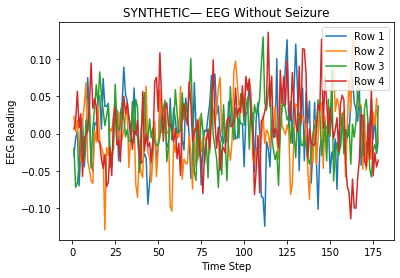

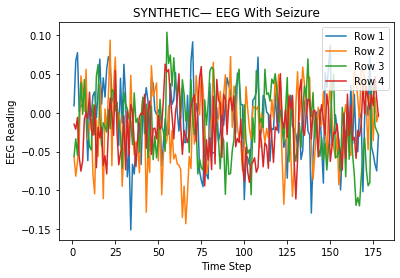

In [29]:
# Generate data for class 0
X_synthetic_0 = train.generate_synthetic_data(NUM_SYNTHETIC_SAMPLES, G_0, latent_dim, seq_length)
Y_synthetic_0 = np.zeros(NUM_SYNTHETIC_SAMPLES)

# Plot the synthetic data for class 1
synth_X0_plot = X_synthetic_0.reshape((NUM_SYNTHETIC_SAMPLES, seq_length))
for i in range(1, 5):
    plt.plot([x for x in range(1, seq_length+1)], synth_X0_plot[i], label="Row {}".format(i))
plt.xlabel('Time Step')
plt.ylabel('EEG Reading')
plt.title('SYNTHETIC— EEG Without Seizure')
plt.gca().legend(loc="upper right")
#plt.ylim([-150, 150])
plt.show()
    

# Generate data for class 1
X_synthetic_1 = train.generate_synthetic_data(NUM_SYNTHETIC_SAMPLES, G_1, latent_dim, seq_length)
Y_synthetic_1 = np.ones(NUM_SYNTHETIC_SAMPLES)

# Plot the synthetic data for class 1
synth_X1_plot = X_synthetic_1.reshape((NUM_SYNTHETIC_SAMPLES, seq_length))
for i in range(1, 5):
    plt.plot([x for x in range(1, seq_length+1)], synth_X1_plot[i], label="Row {}".format(i))
plt.xlabel('Time Step')
plt.ylabel('EEG Reading')
plt.title('SYNTHETIC— EEG With Seizure')
plt.gca().legend(loc="upper right")
#plt.ylim([-1000, 500])
plt.show()

plt.close()

Lastly, we'll train a classifier on the synthetic data, and test it on the real data:

In [30]:
# Build the synthetic dataset (combine generated data from both classes)
X_synthetic = np.concatenate((X_synthetic_0, X_synthetic_1), axis=0)
print(X_synthetic.shape)
Y_synthetic = keras.utils.np_utils.to_categorical\
    (np.concatenate((Y_synthetic_0, Y_synthetic_1), axis=0))
print(Y_synthetic.shape)

# Classifier trained here!
tstr_model = createClassifier(input_shape)
tstr_results = tstr_model.fit(X_synthetic, Y_synthetic, validation_data=(test_X, test_Y),\
        epochs=NUM_TSTR_CLASSIFIER_EPOCHS, batch_size = 64, shuffle=True)

(4000, 178, 1)
(4000, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 178, 128)          768       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 89, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 89, 96)            61536     
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 89, 64)            30784     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 89, 48)            15408     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 44, 48)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 44, 32)        

KeyboardInterrupt: 